In [1]:
import pandas as pd
# import cugraph as cnx
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product
from collections import Counter, defaultdict
import plotly.graph_objects as go
from multiprocessing import Pool
import numpy as np
from itertools import combinations
from netwulf import visualize
import netwulf as nw
import matplotlib.pyplot as plt

In [2]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [194]:
R = pd.read_pickle("edgelist_reindexed.pkl")
sanc = pd.read_csv("sanctioned_russians.csv")
R._start_name = R._start_name.str.lower()
sanc.Name = sanc.Name.str.lower()

In [7]:
OFF = pd.read_csv("full-oldb-20220110/nodes-officers.csv")
OFF.name = OFF.name.str.lower()
OFF = OFF[~OFF.name.isna()]

C:\Users\User\anaconda3\envs\networks\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (3,4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
matches = ["elena georgieva fournadjieva",
           "boris rotenberg", "rotenberg - boris","rotenberg - boris", 
           "mr. igor rotenberg", 
           "guennadi timtchenko",
          "alisher usmanov",
           "vladimir bogdanov", 
           "oleg deripaska",
          "sergei ivanov","ivanov sergei", "sergey ivanov", "mr serguei ivanov","ivanov sergey", 
           "kerimov - suleyman", 
           "vladimir kiriyenko", 
           "arkady rotenberg","rotenberg - arkady",
           "soloviev yuri", 
           "mordashov - alexey",
           "ponomarenko - alexander",
           "sergey roldugin", "sergey pavlovich roldugin", # 15/40
           "igor osipov", 
           "vladimir solovyev",
          ]
OFF["is_sanctioned"] = OFF.name.isin(matches)
sanc_id = OFF[OFF.is_sanctioned]._id.values
OFF[OFF.is_sanctioned].shape

(49, 9)

In [20]:
#re_id_names
list_of_oligarchs = [[o] for o in matches]
boris_rotenberg  = ["boris rotenberg", "rotenberg - boris","rotenberg - boris", ]
sergei_ivanov    = ["sergei ivanov", "ivanov sergei", "sergey ivanov", "mr serguei ivanov","ivanov sergey",]
arkady_rotenberg = ["arkady rotenberg","rotenberg - arkady",]
sergey_roldugin  = ["sergey roldugin", "sergey pavlovich roldugin",]
list_of_oligarchs += [boris_rotenberg, sergei_ivanov, arkady_rotenberg, sergey_roldugin]

re_id = {}
for oligarch in list_of_oligarchs:
    dff = OFF[ OFF.name.isin(oligarch) ]
    id_min = dff._id.min()
    for i,r in dff.iterrows():
        re_id[r._id] = id_min
sanc_id = np.array([re_id.get(x,x) for x in sanc_id])

## Oligarch Network

In [2]:
D1 = pd.read_csv("Data/nodes-addresses.csv")
D2 = pd.read_csv("Data/nodes-entities.csv")
D3 = pd.read_csv("Data/nodes-intermediaries.csv")
D4 = pd.read_csv("Data/nodes-officers.csv")

id2type = {x:"Address" for x in D1._id.values}
id2type.update( {x:"Entity" for x in D2._id.values} )
id2type.update( {x:"Intermediaries" for x in D3._id.values} )
id2type.update( {x:"Officers" for x in D4._id.values} )

C:\Users\User\anaconda3\envs\networks\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (3,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\User\anaconda3\envs\networks\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (3,4,7,8,11,12,13,14,15,16,17,18,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\User\anaconda3\envs\networks\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (3,4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
id2name = dict(zip(D1._id.values, D1.address.values))
id2name.update( dict(zip(D2._id.values, D2.name.values)) )
id2name.update( dict(zip(D3._id.values, D3.name.values)) )
id2name.update( dict(zip(D4._id.values, D4.name.values)) )

In [25]:
id2country = dict(zip(D1._id.values, D1.country_codes.values)) 
id2country.update( dict(zip(D2._id.values, D2.country_codes.values)) )
id2country.update( dict(zip(D3._id.values, D3.country_codes.values)) )
id2country.update( dict(zip(D4._id.values, D4.country_codes.values)) )

In [26]:
R22 = R[(R._start_type == "Intermediaries") & (R._end_type == "Entity")].copy()
R22.loc[:,["_start", "_end"]] = R22.loc[:,["_end", "_start"]].values
R22.loc[:,["_start_type", "_end_type"]]       = R22.loc[:,["_end_type", "_start_type"]].values
R22.loc[:,["_start_country", "_end_country"]] = R22.loc[:,["_end_country", "_start_country"]].values
R22.loc[:,["_start_name", "_end_name"]]       = R22.loc[:,["_end_name", "_start_name"]].values
R22 = pd.concat((R, R22))
R22 = R22[~((R22._start_type == "Intermediaries") & (R22._end_type == "Entity"))]
R22._start = R22._start.apply(lambda x: re_id.get(x,x))
R22._end = R22._end.apply(lambda x: re_id.get(x,x))

In [31]:
sanc_id2 = set( [re_id[x] for x in sanc_id] )

In [32]:
%%time
G = nx.DiGraph()
G.add_edges_from(R22[["_start", "_end"]].values)
G_U = G.to_undirected()

Wall time: 15.8 s


In [61]:
%%time
shortest_paths    = {}
shortest_path_len = defaultdict(lambda: 999)

for k, (i,j) in enumerate( list( combinations(sanc_id2,2) ) ): 
    a = nx.shortest_path(G_U,i,j)
    if shortest_path_len[i] > len(a) :
        shortest_paths[i] = a
        shortest_path_len[i] = len(a)
    if shortest_path_len[j] > len(a) : 
        shortest_paths[j] = a
        shortest_path_len[j] = len(a)

    if (k % 10) == 0:
        print(k)
subnodes = set( [item for sublist in paths for item in sublist] )

0
10
20
30
40
50
60
70
80
90
100
110
120
130
Wall time: 12.1 s


In [70]:
%%time
SP = {}
for k, (i,j) in enumerate( list( combinations(sanc_id2,2) ) ): 
    SP[(i,j)] = nx.shortest_path(G_U,i,j)

Wall time: 12.1 s


In [33]:
%%time
trees = {}
for i,n in enumerate(sanc_id2):
#     print(i)
    try:
        trees[n] = list( nx.dfs_edges(G, source=n, depth_limit=None) )
    except KeyError:
        print(n)
flat_list = [item for sublist in trees.values() for item in sublist]
nodes = set( [item for sublist in flat_list for item in list(sublist)] )

Wall time: 500 µs


In [34]:
id2type.update(dict(zip(sanc_id2, ["Oligarch"]*len(sanc_id2))))
type2col = {"Intermediaries": "cyan", "Entity":"blue", "Oligarch":"yellow",
            "Officers":"green", "Address": "grey" }
flat_list = [item for sublist in list( shortest_paths.values() )
             for item in sublist]
G1   = G.subgraph(list(nodes) + list(subnodes) )
G_U1 = G1.to_undirected()

In [85]:
%%time
comps = sorted(nx.connected_components(G_U1), key=len, reverse=True)

while len(comps) > 1:
    cc_paths = []
    for i,cc in enumerate(comps):
        olig1 = [c for c in cc if id2type[c] == "Oligarch"]


        min_dist = 999
        shortest_path = []

        for j,cd in enumerate(comps):
            if i == j:
                continue
            olig2 = [c for c in cd if id2type[c] == "Oligarch"]

            for x in olig1:
                for y in olig2:
                    try:
                        path = SP[(x,y)]
                    except:
                        path = SP[(y,x)]
                if len(path) < min_dist:
                    min_dist = len(path)
                    shortest_path = path
        cc_paths.append(shortest_path)

    new_edges = []
    for F in cc_paths:
        new_edges += [(F[i], F[i+1]) for i,f in enumerate(F[:-1])]

    G_U1.add_edges_from(new_edges)
    comps = sorted(nx.connected_components(G_U1), key=len, reverse=True)
    
leaves = [1]
while len(leaves) > 0:
    leaves = [x for x in G_U1.nodes() if G_U1.degree()[x] == 1]
    leaves = [x for x in leaves if id2type[x] != "Oligarch"]
    G_U1.remove_nodes_from(leaves)

Wall time: 1.5 ms


In [94]:
for k, v in G_U1.nodes(data=True):
    v["group"] = type2col[ id2type[k] ]
    v["label"] = id2name.get(k,k)

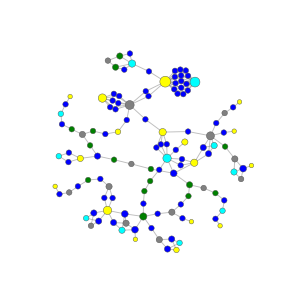

In [95]:
stylized_network, config = visualize(G_U1,)

In [116]:
hitlist = [
           216903,218283,1206618, 
          ]
[id2name[n] for n in hitlist]

['Bridgewaters Limited', 'Markom Management LTD', '33-37 Athol Street']

In [112]:
id2name[216903] = "Bridgewaters Limited"
id2name[218283] = "Markom Management LTD"
id2name[1616030] = "3rd Floor, Yamraj Building, BVI"

In [124]:
orig_names = [ id2name[n] for n in id2name.keys() if id2type[n] == "Oligarch"]
new_names  = ["S. Roldugin", "I. Rotenberg", "G. Timtchenko", "S. Yuri", "A. Usmanov", "O. Deripaska",
             "A. Rotenberg", "B. Rotenberg", "I. Osipov", "S. Ivanov", "V. Solovyev", "V. Bogdanov", "A. Mordashov",
             "A. Ponomarenko", "S. Kerimov", "V. Kiriyenko", "E. Georgieva"]
restyle_oligarch = dict(zip(orig_names, new_names))

216903
218283
1206618


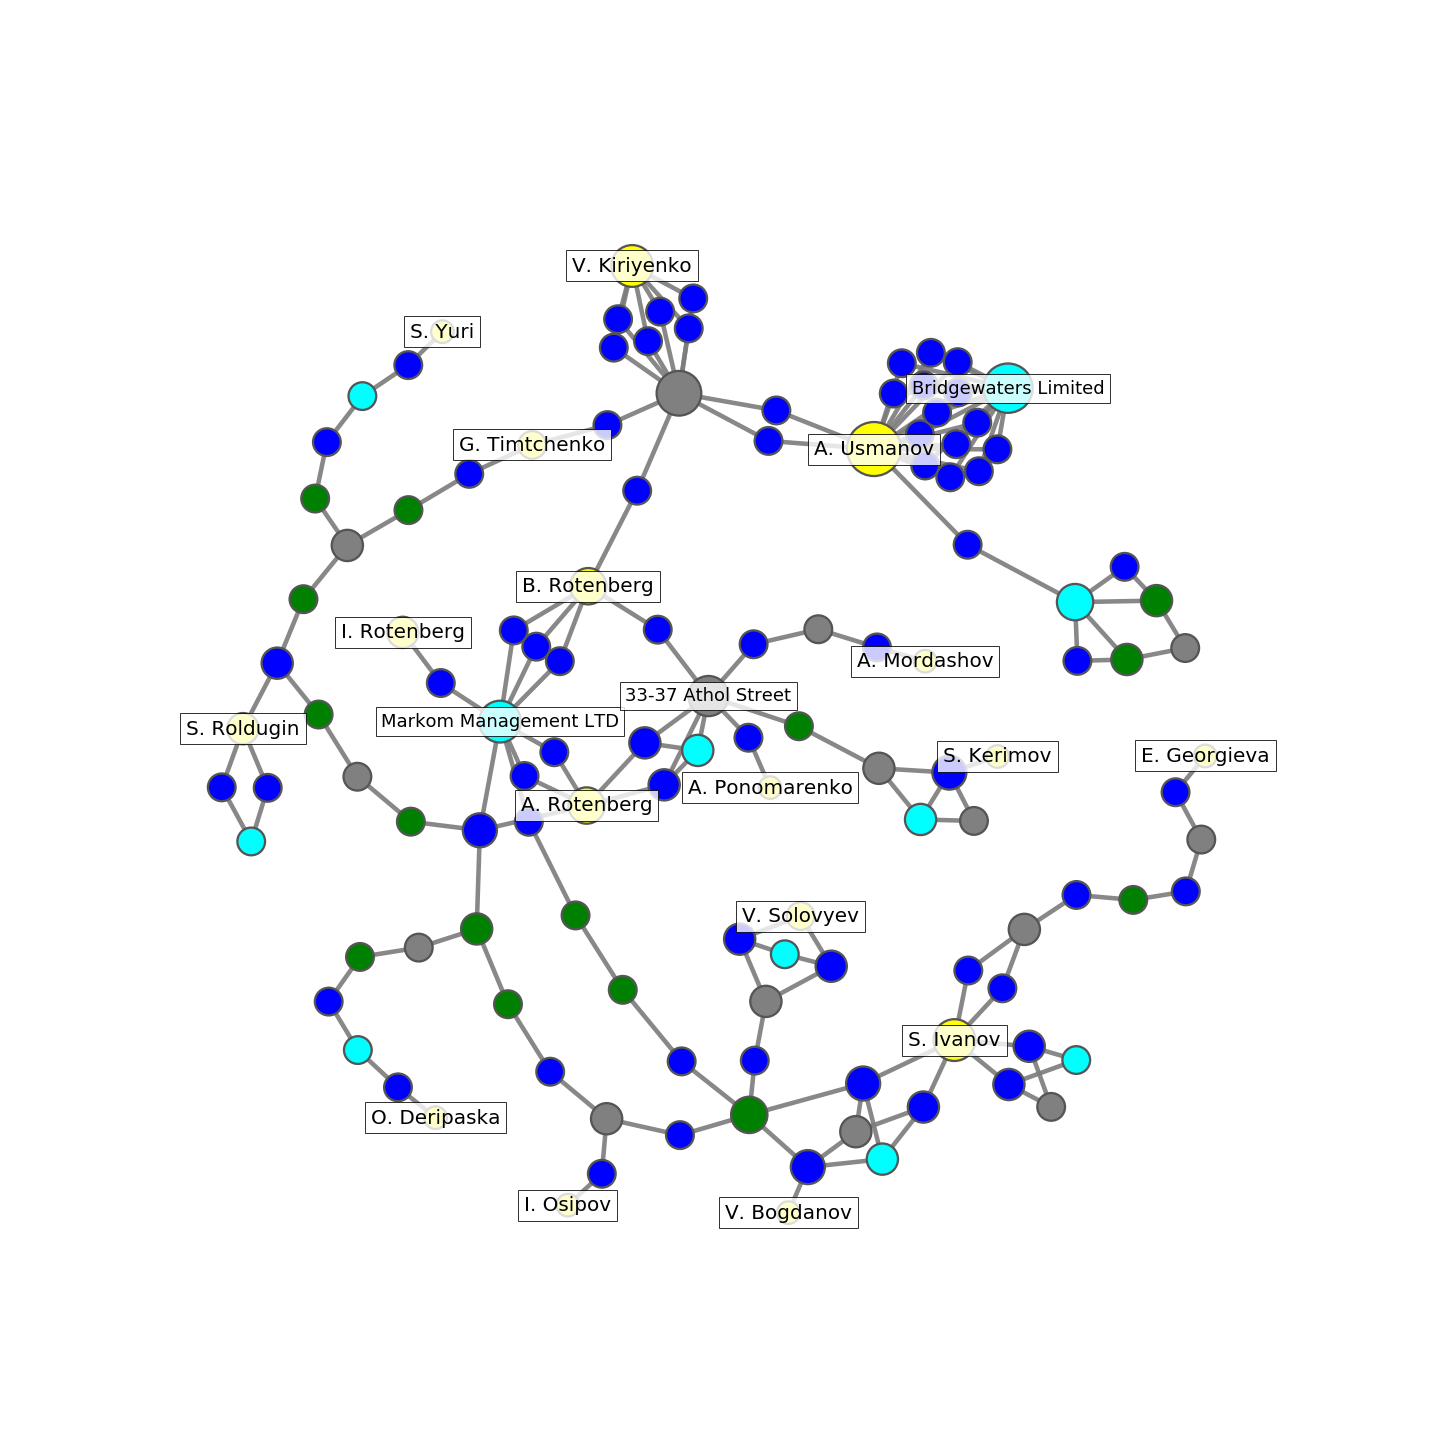

In [125]:
fig, ax = nw.draw_netwulf(stylized_network,figsize=20)

box = dict(facecolor='white', alpha=0.8, boxstyle='square')
for n in sanc_id2:
    nw.add_node_label(ax,stylized_network,n,restyle_oligarch[id2name[n]], fontsize=20,
                     bbox = box)

for n in hitlist:
    print(n)
    if id2type[n] == "Address":
        nw.add_node_label(ax,stylized_network,n,id2name[n], fontsize=18, bbox = box)
    else:
        nw.add_node_label(ax,stylized_network,n,id2name[n], fontsize=18,
                     bbox = box)  
    
plt.savefig("figures/Oligarch-network-merged.png")

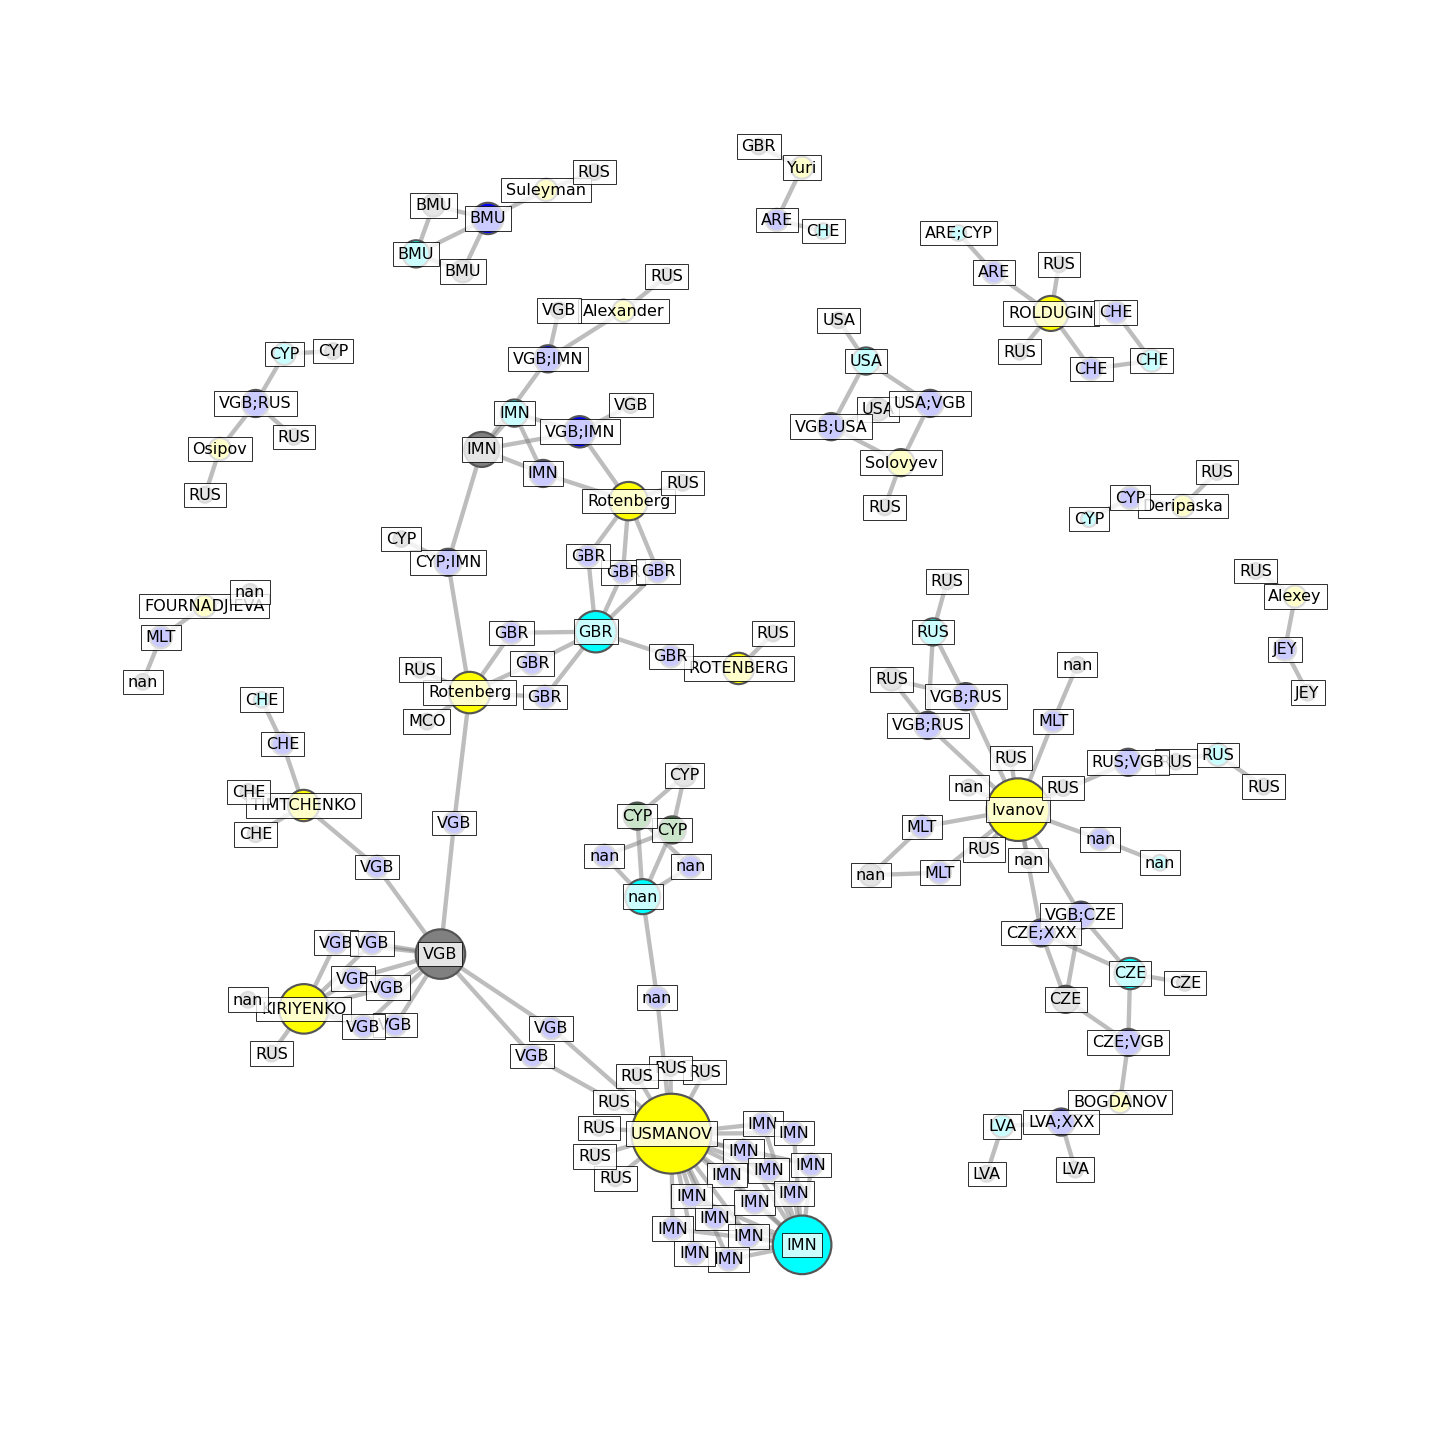

In [26]:
fig, ax = nw.draw_netwulf(stylized_network,figsize=20)

box = dict(facecolor='white', alpha=0.8, boxstyle='square')
for n in sanc_id2:
    nw.add_node_label(ax,stylized_network,n,id2name[n].split(" ")[-1], fontsize=16,
                     bbox = box)

for n in G_U.nodes():
    if n in sanc_id2:
        continue
    nw.add_node_label(ax,stylized_network,n,id2country[n], fontsize=16, bbox = box)
    
plt.savefig("figures/Oligarch-network-countries.png")